# NLOCPSolver.jl

## Installation

There are several packages that need to be installed, to do this run:
```julia
import Pkg
Pkg.add("JuMP")
Pkg.add("Parameters")
Pkg.add("DataFrames")
Pkg.add("Ipopt")
```

Also, a plotting backend will be required and there are several options:
```julia
Pkg.add("Plots")
```

## Packages that will be used

In [24]:
using JuMP, NLOCPSolver, Plots, 

Base.Meta.ParseError: ParseError:
# Error @ c:\Users\19114\.julia\dev\NLOCPSolver\tutorial.ipynb:1:33
using JuMP, NLOCPSolver, Plots, 
#                               └ ── premature end of input

## Example: Bicycle Obstacle Avoidance
### Given:
#### Control the vehicle (defined as bicycle model) to avoid an circular obstacle.
#### States
$$X=\begin{bmatrix}x \\y \\v \\r \\\psi \\u_x \\\delta_f\end{bmatrix}=\begin{bmatrix}\text{global x position} \\\text{global y position} \\\text{lateral speed} \\\text{yaw rate} \\\text{yaw angle} \\\text{longitudinal speed} \\\text{front tire steering angle}\end{bmatrix}$$
#### Control inputs
$$U =\begin{bmatrix}a_x \\\dot{\delta_f}\end{bmatrix}=\begin{bmatrix}\text{longitudinal acceleration} \\\text{front tire steering rate}\end{bmatrix}$$
#### The equations of motion are given as
$$\dot{X}(t)=\begin{bmatrix}u_x(t)\cos(\psi(t))-v(t)\sin(\psi(t)) \\u_x(t)\sin(\psi(t))+v(t)\cos(\psi(t)) \\(F_{yf}+F_{yr})/m-u_x(t)r(t) \\(F_{yf}l_a-F_{yr}l_b)/I_{zz} \\r(t) \\a_x(t) \\\dot{\delta_f}\end{bmatrix}$$
where
$$F_{zf}=mg\cdot \frac{l_a}{l_a+l_b}-\frac{mh}{l_a+l_b}\cdot a_x(t)$$
$$F_{zr}=mg\cdot \frac{l_b}{l_a+l_b}+\frac{mh}{l_a+l_b}\cdot a_x(t)$$
$$F_{yf}=f(\alpha_f,F_{zf},\mu)$$
$$F_{yr}=f(\alpha_r,F_{zr},\mu)$$
$$\alpha_f=\delta_f-(v+l_a\cdot r)/u_x$$
$$\alpha_r=-(v-l_b\cdot r)/u_x$$
$$f(\alpha,F_z,\mu)=\mu\cdot F_z\sin(1.817\cdot \arctan(\frac{5.68}{\mu}\cdot \alpha))$$
#### Boundary Conditions
$$X(0)=[-10,0,0,0,0,10,0]'$$
$$X(t_f)=free$$
where $$t_f=8s$$
States upper bound
$$XU = [300, 20, 3, \pi/5, \pi/2, 15.0, \pi/12]'$$
States lower bound
$$XL = [-40, -20, -3, -\pi/5, -\pi/2, 5.0, -\pi/12]'$$
Control input upper bound
$$CU = [2.6, 0.1]'$$
Control input lower bound
$$CL = [-2.6, -0.1]'$$
#### Obstacle information
The obstacle is formulated as a circle and is placed at (30,2) with radius $$r=6$$
### Find:
#### The track that minimizes the cost function
$$J=\int_{t_0}^{t_f} 0.05\cdot y^2+2\cdot\dot{\delta_f}^2+0.2\cdot a_x^2+0.2\cdot (u_x-13)^2+\delta_f^2dt$$

### Solution: 

#### Define state space model

We first set up the state space model based on the equations of motion and the related parameters:

In [25]:
la = 1.56; 
lb = 1.64;
m = 2020;
g = 9.81;
Izz = 4095;
h = 0.6;
mu = 0.8;
function MagicFormula(alpha, Fz, mu)
    B =  5.68   # Input Q2b value here
    C =  1.817   # Input Q2b value here
    Fy =  mu*Fz*sin(C*atan(B/mu*alpha))  # Lateral force calculation
    return Fy
end

function bicycleModel_expr(states, controls, parameters)
    x = states[1]
    y = states[2]
    v = states[3]
    r = states[4]
    ψ = states[5]
    ux = states[6]
    δf = states[7]
    ax = controls[1]
    dδf = controls[2]
    Fzf = m*g*la/(la+lb) - m*h/(la+lb)*ax # Front axle load
    Fzr = m*g*lb/(la+lb) + m*h/(la+lb)*ax # Rear axle load

    αf = δf - (v+la*r)/ux # Front slip angle
    αr = -(v-lb*r)/ux # Rear slip angle

    Fyf = MagicFormula(αf, Fzf, mu) # Front lateral force
    Fyr = MagicFormula(αr, Fzr, mu) # Rear lateral force

    dstates = Vector{Any}(undef,7)
    dstates[1]         = ux*cos(ψ) - v*sin(ψ) 
    dstates[2]         = ux*sin(ψ) + v*cos(ψ)  
    dstates[3]         = (Fyf+Fyr)/m - ux*r  
    dstates[4]         = r 
    dstates[5]         = (Fyf*la-Fyr*lb)/Izz 
    dstates[6]         = ax 
    dstates[7]         = dδf 
    
    return dstates
end

bicycleModel_expr (generic function with 1 method)

Write down the boundary conditions, including the initial and final conditions, boundary for states variables and control input. (`NaN` means the boundary is free)

In [26]:
XL = [-40, -20, -3, -pi/5, -pi/2, 5.0, -pi/12];
XU = [300, 20, 3, pi/5, pi/2, 15.0, pi/12];
CL = [-2.6, -0.1];
CU = [2.6, 0.1];
X0 = [-10.0, 0, 0, 0, 0, 10.0, 0];
XF = [NaN, NaN, NaN, NaN, NaN, NaN, NaN];

#### Define the Problem:
Define the optimal control problem through `defineOCP()` with the number of states, the number of control inputs, and the boundary conditions.
Use `defineStates!()` and `defineControls!()` to add variable names for the defined model.

In [27]:
ocp = defineOCP(numStates=7, numControls=2, X0=X0, XF=XF, XL=XL, XU=XU, CL=CL, CU=CU);
defineStates!(ocp, [:x, :y, :v, :r, :ψ, :ux, :δf])
defineControls!(ocp, [:ax, :dδf])

#### Basics
Variable | Description
:--- | :--- 
`numStates` | the number of states
`numControls` | the number of controls
`X0` | intial state constraint
`XF` | final state constraint
`XL` | lower state bound
`XU` | upper state bound
`CL` | lower state bound
`CU` | upper control bound


#### Configure the Problem:
Now that the basic optimal control problem has been defined. Next we need to further configure the problem by adding the information for the number of points, final time, and integration method.  
For this example, we will choose 81 points with a fixed final time 8s. The backward Euler method is applied for integration.

In [28]:
OCPForm = ConfigurePredefined(ocp; (:Np => 81), (:tfDV => false), (:tf => 8), (:IntegrationScheme => :bkwEuler), (:dx => bicycleModel_expr))
OCPdef!(ocp, OCPForm)

#### Settings:
Key | Description
:--- | :--- 
`:Np` | number of points for the simulation interval
`:tfDV` | bool to indicate if time is a design variable
`:tf` | provide the final time if tfDV is not a design variable
`:IntegrationScheme` | integration scheme
`:dx` | derivative of the states defined based on the equations of motions
#### Notice:
1. if final time is a design variable (for example, we want to minimize the time), then the value of `:tf` is not required.

#### Integration Schemes:
Key | Description
:--- | :--- 
`:bkwEuler` | backward Euler
`:trapezoidal` | trapezoidal approximation rule
`:RK1` | Runge-Kutta first order
`:RK2` | Runge-Kutta second order
`:RK3` | Runge-Kutta third order
`:RK4` | Runge-Kutta fourth order


#### Add obstacle as a constraint
Define the obstacle as a circle placed at (30,2) with radius r=6.

In [29]:
xpos = ocp.p.x[:, 1];
y = ocp.p.x[:, 2]; dδf = ocp.p.u[:, 2]; ax = ocp.p.u[:, 1]; ux = ocp.p.x[:, 6]; δf = ocp.p.x[:, 7];
obs_cons = @constraint(ocp.f.mdl, [i=1:ocp.s.states.pts], 36 <= ((xpos[i] - 30).^2 + (y[i] - 2).^2));

#### Objective Function
The objective function needs to be defined. For this, we use the ``JuMP`` macro ``@expression()`` and ``@objective()`` directly as:

In [30]:

obj = @expression(ocp.f.mdl, sum((0.05 * (y[j])^2 + 2 * dδf[j]^2 + 0.2 * ax[j]^2 + 0.2 * (ux[j] - 13)^2 + 1 * δf[j]^2) * ocp.f.TInt[j-1] for j in 2:ocp.f.Np));
@objective(ocp.f.mdl, Min, obj);


with,

Variable | Description
:--- | :--- 
`ocp.f.mdl` | object that holds them JuMP model (generated by `OCPdef!`) 
`Min` | for a minimization problem
`obj` | objective function expression

#### Optimize
Now that the entire optimal control problem has been defined we can `OptSolve!()` it as:

In [31]:
@time OptSolve!(ocp)

  0.319589 seconds (267.26 k allocations: 14.051 MiB)


#### Optimized track results:
We can now plot the results to check that the track is able to avoid obstacle.

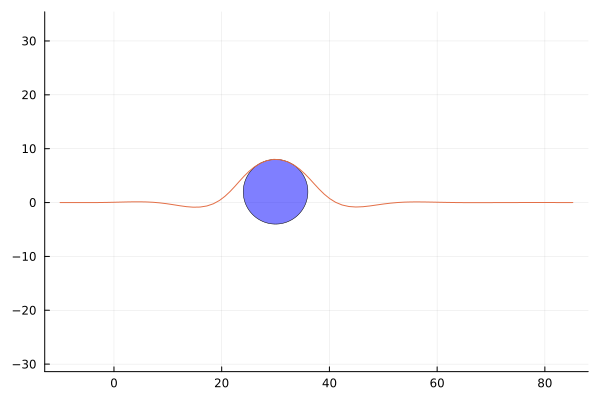

In [32]:
function circleShape(h,k,r)
    theta = LinRange(0,2*pi,500)
    h .+ r*sin.(theta), k .+ r*cos.(theta)
end
plot()
plot!(circleShape(30,2,6), seriestype = [:shape,], lw=0.5, c=:blue, linecolor=:black, legend=false, fillalpha=0.5, aspect_ratio=1)
plot!(ocp.r.X[:, 1], ocp.r.X[:, 2], aspect_ratio = 1)